In [2]:
import modern_robotics as mr
import numpy as np
import math
def MyJaco(thetalist):
    t1, t2 = thetalist[0], thetalist[1]
    J1 = np.array([0, 1, 0, -100, 0, 0])
    J2 = np.array([np.sin(t1), 0, np.cos(t1), -98*np.cos(t1), 100*np.sin(t1), 98*np.sin(t1)])
    J3 = np.array([np.cos(t1)*np.sin(t2), -np.cos(t2), -np.sin(t1)*np.sin(t2), -105*np.sin(t1)+98*np.sin(t1)*np.sin(t2)+100*np.cos(t2), 100*np.cos(t1)*np.sin(t2), -105*np.cos(t1) + 98*np.cos(t1)*np.sin(t2)])
    return np.array([J1, J2, J3]).T

In [23]:
def PoE_3D(theta1, theta2, theta3):
    M = np.array([
        [1, 0, 0, (105 + 55.95 + 57.75)/1000],
        [0, 1, 0, (-98 + (-15))/1000],
        [0, 0, 1, (100 - 12.31)/1000],
        [0, 0, 0, 1]
    ])
    omega_1 = np.array([0,1,0])
    omega_2 = np.array([0,0,1])
    omega_3 = np.array([0,-1,0])

    q_1 = np.array([0,-98,100])/1000
    q_2 = np.array([0,-98,100])/1000
    q_3 = np.array([105,-113,100])/1000

    v_1 = - np.cross(omega_1,q_1)
    v_2 = - np.cross(omega_2,q_2) 
    v_3 = - np.cross(omega_3,q_3) 
    
    S1 = mr.MatrixExp6(mr.VecTose3(np.concatenate((omega_1,v_1),axis=0))*theta1)
    S2 = mr.MatrixExp6(mr.VecTose3(np.concatenate((omega_2,v_2),axis=0))*theta2)
    S3 = mr.MatrixExp6(mr.VecTose3(np.concatenate((omega_3,v_3),axis=0))*theta3)

    T_05 = S1.dot(S2).dot(S3).dot(M)
    return T_05[0:3,3]

In [4]:
def inv(matrix):
    def adjoint(matrix): #matrix is a numpy 3x3 array and if any other stuff is passed it will throw an error.
        mtrx = [matrix[0][0], matrix[0][1], matrix[0][2], matrix[1][0], matrix[1][1], matrix[1][2], matrix[2][0], matrix[2][1], matrix[2][2]] 
        A= +((mtrx[4]*mtrx[8])-(mtrx[5]*mtrx[7]))
        B= -((mtrx[3]*mtrx[8])-(mtrx[5]*mtrx[6]))
        C= +((mtrx[3]*mtrx[7])-(mtrx[6]*mtrx[4]))
        D= -((mtrx[1]*mtrx[8])-(mtrx[2]*mtrx[7]))
        E= +((mtrx[0]*mtrx[8])-(mtrx[2]*mtrx[6]))
        F= -((mtrx[0]*mtrx[7])-(mtrx[1]*mtrx[6]))
        G= +((mtrx[1]*mtrx[5])-(mtrx[2]*mtrx[4]))
        H= -((mtrx[0]*mtrx[5])-(mtrx[2]*mtrx[3]))
        I= +((mtrx[0]*mtrx[4])-(mtrx[1]*mtrx[3]))
        #Convert back to 3x3 matrix format
        return  [[A, D, G], 
                 [B, E, H], 
                 [C, F, I]]
    def det(a):
        return (a[0][0] * (a[1][1] * a[2][2] - a[2][1] * a[1][2])
               -a[1][0] * (a[0][1] * a[2][2] - a[2][1] * a[0][2])
               +a[2][0] * (a[0][1] * a[1][2] - a[1][1] * a[0][2]))
    
    matrix_adj = adjoint(matrix)
    matrix_det = det(matrix)
    for i in range(3):
        for j in range(3):
            matrix_adj[i][j] = matrix_adj[i][j]/matrix_det
    
    return matrix_adj

In [5]:
import math
def calculateDeltaQ(thetalist, deltaX):
    t1, t2 = thetalist[0], thetalist[1]
    # J1 = [0, 1, 0, -100, 0, 0]
    # J2 = [math.sin(t1), 0, math.cos(t1), -98*math.cos(t1), 100*math.sin(t1), 98*math.sin(t1)]
    # J3 = [np.cos(t1)*np.sin(t2), -np.cos(t2), -np.sin(t1)*np.sin(t2), -105*math.sin(t1)+98*math.sin(t1)*math.sin(t2)+100*math.cos(t2), 100*math.cos(t1)*math.sin(t2), -105*math.cos(t1) + 98*math.cos(t1)*math.sin(t2)]
    J1 = [-100, 0, 0]
    J2 = [-98*math.cos(t1), 100*math.sin(t1), 98*math.sin(t1)]
    J3 = [-105*math.sin(t1)+98*math.sin(t1)*math.sin(t2)+100*math.cos(t2), 100*math.cos(t1)*math.sin(t2), -105*math.cos(t1) + 98*math.cos(t1)*math.sin(t2)]
    temp_matrix = [J1, J2, J3]
    # Transpose Matrix
    jacobian = [[temp_matrix[i][j] for i in range(3)] for j in range(3)]
    print(jacobian)
    inverse_jacobian = inv(jacobian)
    
    deltaQ = [sum([inverse_jacobian[i][j] * deltaX[j] for j in range(3)]) for i in range(3)]
    return [rad * 180 / math.pi for rad in deltaQ]

In [7]:
thetalist = np.array([0, 0, 7])
X = PoE_3D(*np.deg2rad(thetalist))[0:3,3]
# X

theta_target = np.array([0, 0, 7])
X_target = PoE_3D(*np.deg2rad(theta_target))[0:3,3]
deltaX = X_target - X
calculated_theta = calculateDeltaQ(np.deg2rad(thetalist), deltaX)
print(calculated_theta)

[[-100, -98.0, 100.0], [0, 0.0, 0.0], [0, 0.0, -105.0]]


ZeroDivisionError: float division by zero

In [ ]:
S1 = np.array([0, 1, 0, -100, 0, 0])
S2 = np.array([0, 0, 1, -98, 0, 0])
S3 = np.array([0, -1, 0, 100, 0, -105])

In [8]:
S1 = np.array([0, 1, 0, -100, 0, 0])
S2 = np.array([0, 0, 1, -98, 0, 0])
S3 = np.array([0, -1, 0, 100, 0, -105])

for t1 in range(20, 60):
    for t2 in range(20, 60):
        for t3 in range(20, 60):
            thetalist = np.array([t1,t2,t3])
            X_c = PoE_3D(*np.deg2rad(thetalist))[0:3,3]
            J = mr.JacobianSpace(np.array([S1, S2, S3]).T, np.deg2rad(thetalist))
            pseudo_J = np.linalg.inv(J.T.dot(J)).dot(J.T)[:,3:]
            J_inv = np.linalg.inv(J[3:,:])

            theta_target = np.array([t1+1,t2+1,t3+1])
            X_target = PoE_3D(*np.deg2rad(theta_target))[0:3,3]

            deltaX = X_target - X_c

            # pseudo_J.dot(deltaX)
            # J_inv.dot(deltaX)
            # print(np.rad2deg(pseudo_J.dot(deltaX)))
            # print(np.rad2deg(J_inv.dot(deltaX)))
            delta = np.rad2deg(J_inv.dot(deltaX))
            if np.isclose(delta, theta_target - thetalist, atol=0.1).all():
                print(thetalist)
                print(delta)
                print(theta_target - thetalist)
                print("\n")

In [42]:
MyJaco(thetalist)

array([[ 0.00000000e+00,  6.42787610e-01,  7.64178397e-01],
       [ 1.00000000e+00,  0.00000000e+00,  6.97564737e-02],
       [ 0.00000000e+00,  7.66044443e-01, -6.41221811e-01],
       [-1.00000000e+02, -7.50723554e+01, -1.16286089e+01],
       [ 0.00000000e+00,  6.42787610e+01,  7.64178397e+01],
       [ 0.00000000e+00,  6.29931857e+01, -5.54518359e+00]])

In [43]:
for i in range(8):
    deltaX = np.random.uniform(0, 10, 3)
    thetalist = np.random.uniform(0, 2*np.pi, (3, ))
    Jexp = mr.JacobianSpace(np.array([S1, S2, S3]).T, thetalist)
    # print(Jexp)
    Jexp = Jexp[3:, :]
    Qexp = np.linalg.inv(Jexp).dot(deltaX)
    Jact = MyJaco(thetalist)
    Qact = InverseJacobian(thetalist, deltaX)
    print(Qexp)
    print(Qact)
    print(np.isclose(Qexp, Qact))
    print("================")

[ 0.28956128 -0.01879539  0.18110839]
[0.2895612825316367, -0.018795389929373033, 0.18110838862178325]
[ True  True  True]
[ 0.23107433  0.15958354 -0.06146201]
[0.23107433199090516, 0.15958354310055214, -0.061462014498526]
[ True  True  True]
[-0.07294    -0.02778982  0.01639988]
[-0.07293999781232269, -0.027789816442862807, 0.016399884050631773]
[ True  True  True]
[-0.13035639 -0.06727444 -0.02148316]
[-0.13035639376995323, -0.06727444356304293, -0.02148315575491691]
[ True  True  True]
[-0.17187652  0.09741983 -0.09552628]
[-0.17187652218398913, 0.09741982759977287, -0.09552627820032328]
[ True  True  True]
[ 0.04700472  0.07510077 -0.31091589]
[0.04700471589050548, 0.07510077113274576, -0.31091588622653754]
[ True  True  True]
[-0.02853519 -0.03357431  0.02148808]
[-0.02853518704992189, -0.03357431465607254, 0.021488084683379087]
[ True  True  True]
[-0.16402967 -0.17635485 -0.10614468]
[-0.1640296678509262, -0.17635485089448877, -0.10614467671736981]
[ True  True  True]


In [119]:
thetalist = np.deg2rad(np.array([0, 10, 10]))
J = mr.JacobianSpace(np.array([S1, S2, S3]).T, np.deg2rad(thetalist))
print(J)
print(np.linalg.det(J.dot(J.T)))
print(np.linalg.det(J[3:,:]))

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00 -1.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-1.00000000e+02 -9.80000000e+01  1.00000000e+02]
 [ 0.00000000e+00  9.98796232e-19  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.05000000e+02]]
0.0
1.0487360435605466e-14


In [129]:
S1 = np.array([0, 1, 0, -100, 0, 0])
S2 = np.array([0, 0, 1, -98, 0, 0])
S3 = np.array([0, -1, 0, 100, 0, -105])

xyz = [[0.2165269048192407, 0.21652464813330263, 0.21650940733665613, 0.21646969592598683, 0.21639559770476274, 0.21627869699182134, 0.21611200882995737, 0.21588990919451004, 0.21560806520195075, 0.21526336531847023, 0.21485384956856635, 0.21437863974363114, 0.21383786961053874, 0.2132326151202325, 0.21256482461631251, 0.21183724904362325, 0.21105337215684072, 0.21021734072906026, 0.20933389476038358, 0.20840829768650673, 0.2074462665873071, 0.20645390239543115, 0.2054376201048817, 0.2044040789796056, 0.203360112762081, 0.2023126598819047, 0.20126869366438005, 0.20023515253910393, 0.1992188702485545, 0.19822650605667858, 0.19726447495747892, 0.19633887788360205, 0.19545543191492543, 0.1946194004871449, 0.1938355236003624, 0.19310794802767312, 0.19244015752375318, 0.19183490303344689, 0.1912941329003545, 0.19081892307541928, 0.19040940732551537, 0.19006470744203488, 0.18978286344947556, 0.1895607638140283, 0.18939407565216432, 0.18927717493922291, 0.18920307671799877, 0.18916336530732952, 0.18914812451068305, 0.18914586782474496, 0.18914586782474496, 0.18914455744170897, 0.18913570761416146, 0.18911264850877196, 0.18906962211752618, 0.18900174173215606, 0.1889049514185706, 0.18877598549128596, 0.18861232798785604, 0.18841217214330258, 0.18817437986454602, 0.18789844120483545, 0.18758443383817935, 0.18723298253377568, 0.18684521863044257, 0.18642273951104854, 0.18596756807694287, 0.1854821122223862, 0.18496912430898063, 0.18443166064010041, 0.18387304093532217, 0.18329680780485533, 0.18270668622397257, 0.1821065430074401, 0.1815003462839483, 0.18089212497054166, 0.1802859282470498, 0.17968578503051735, 0.1790956634496346, 0.17851943031916775, 0.1779608106143895, 0.17742334694550932, 0.17691035903210373, 0.17642490317754705, 0.17596973174344138, 0.17554725262404733, 0.17515948872071424, 0.1748080374163106, 0.17449403004965444, 0.1742180913899439, 0.17398029911118731, 0.17378014326663388, 0.17361648576320393, 0.1734875198359193, 0.17339072952233386, 0.17332284913696377, 0.17327982274571793, 0.17325676364032846, 0.17324791381278098, 0.17324660342974496, 0.17324660342974496, 0.17324401865447042, 0.17322656206750295, 0.17318107719489237, 0.173096206169254, 0.1729623097916988, 0.1727713875937639, 0.1725169978993432, 0.17219417788661745, 0.17179936364998502, 0.17133031026199216, 0.1707860118352634, 0.1701666215844322, 0.16947337188807093, 0.16870849435062188, 0.16787513986432723, 0.16697729867115968, 0.16601972042475294, 0.16500783425233187, 0.1639476688166433, 0.1628457723778862, 0.16170913285564215, 0.1605450978908058, 0.15936129490751527, 0.15816555117508274, 0.15696581386992453, 0.155770070137492, 0.15458626715420148, 0.15342223218936513, 0.15228559266712108, 0.15118369622836397, 0.15012353079267537, 0.14911164462025436, 0.14815406637384756, 0.14725622518068007, 0.1464228706943854, 0.14565799315693637, 0.14496474346057509, 0.14434535320974382, 0.14380105478301505, 0.14333200139502225, 0.14293718715838982, 0.14261436714566406, 0.14235997745124337, 0.1421690552533085, 0.14203515887575327, 0.14195028785011485, 0.14190480297750435, 0.1418873463905369, 0.1418847616152623, 0.1418847616152623, 0.1418848578481676, 0.14188550776852887, 0.14188720120063533, 0.14189036100545563, 0.1418953460567854, 0.14190245421739495, 0.14191192531517668, 0.14192394411929296, 0.1419386433163233, 0.14195610648641227, 0.1419763710794169, 0.14199943139105436, 0.14202524153904944, 0.14205371843928216, 0.1420847447819355, 0.14211817200764273, 0.14215382328363513, 0.14219149647988957, 0.14223096714527608, 0.14227199148370542, 0.14231430933027667, 0.1423576471274247, 0.14240172090106806, 0.14244623923675614, 0.14249090625581703, 0.1425354245915051, 0.14257949836514844, 0.14262283616229648, 0.14266515400886773, 0.14270617834729707, 0.14274564901268358, 0.14278332220893802, 0.14281897348493042, 0.14285240071063765, 0.14288342705329096, 0.14291190395352374, 0.1429377141015188, 0.14296077441315624, 0.14298103900616088, 0.14299850217624988, 0.14301320137328022, 0.14302522017739647, 0.14303469127517823, 0.14304179943578776, 0.14304678448711752, 0.1430499442919378, 0.14305163772404425, 0.14305228764440556, 0.14305238387731084], [-0.13206076875311867, -0.13205919780572092, -0.13204858822579338, -0.13202094391065006, -0.13196936189569372, -0.13188798377050076, -0.13177194709490625, -0.13161733681508872, -0.13142113667965527, -0.1311811806557264, -0.130896104345021, -0.13056529639994133, -0.1301888499396579, -0.1297675139661945, -0.12930264478051293, -0.12879615739859834, -0.12825047696754385, -0.1276684901816355, -0.12705349669843743, -0.1264091605548766, -0.12573946158332783, -0.12504864682769876, -0.12434118195951474, -0.12362170269400385, -0.12289496620618182, -0.12216580254693686, -0.12143906605911481, -0.12071958679360394, -0.12001212192541993, -0.11932130716979086, -0.11865160819824208, -0.11800727205468124, -0.11739227857148316, -0.11681029178557482, -0.11626461135452032, -0.11575812397260574, -0.11529325478692423, -0.11487191881346077, -0.11449547235317734, -0.11416466440809765, -0.11387958809739226, -0.11363963207346339, -0.11344343193802994, -0.11328882165821244, -0.11317278498261792, -0.11309140685742498, -0.11303982484246859, -0.1130121805273253, -0.11300157094739777, -0.113, -0.113, -0.11300610868129196, -0.11304736438629674, -0.11315486022669756, -0.11335543861030198, -0.11367188016121413, -0.11412309264000692, -0.11472429986389439, -0.11548723062690387, -0.11642030762004829, -0.11752883635149844, -0.11881519406675511, -0.12027901866882154, -0.12191739763837546, -0.1237250569539415, -0.12569455001206337, -0.12781644654747615, -0.13007952155327848, -0.1324709442011049, -0.134976466761298, -0.1375806135230807, -0.14026686971472874, -0.14301787042374248, -0.1458155895170195, -0.14864152856102675, -0.15147690574197278, -0.15430284478598, -0.15710056387925705, -0.15985156458827077, -0.1625378207799188, -0.16514196754170157, -0.16764749010189467, -0.17003891274972105, -0.17230198775552336, -0.17442388429093614, -0.17639337734905802, -0.178201036664624, -0.179839415634178, -0.18130324023624445, -0.18258959795150118, -0.18369812668295127, -0.18463120367609567, -0.1853941344391052, -0.18599534166299259, -0.1864465541417854, -0.18676299569269753, -0.186963574076302, -0.1870710699167028, -0.18711232562170743, -0.18711843430299951, -0.18711843430299951, -0.1871210633172378, -0.18713881867730398, -0.18718508203292256, -0.18727140564372918, -0.18740759368549673, -0.18760178355636148, -0.18786052718304935, -0.188188872327102, -0.188590443891103, -0.18906752522490414, -0.18962113943185138, -0.19025113067501132, -0.19095624548339699, -0.1917342140581944, -0.19258183157898856, -0.19349503950998953, -0.1944690069062588, -0.19549821171993534, -0.19657652210646184, -0.19769727773081083, -0.1988533710737109, -0.20003732873787283, -0.20124139275421585, -0.20245760188809367, -0.20367787294552078, -0.20489408207939858, -0.20609814609574162, -0.20728210375990358, -0.20843819710280362, -0.20955895272715264, -0.21063726311367914, -0.21166646792735566, -0.21264043532362492, -0.2135536432546259, -0.21440126077542004, -0.21517922935021747, -0.21588434415860316, -0.2165143354017631, -0.21706794960871037, -0.21754503094251146, -0.2179466025065125, -0.21827494765056513, -0.21853369127725294, -0.2187278811481177, -0.21886406918988527, -0.21895039280069195, -0.21899665615631048, -0.2190144115163766, -0.21901704053061494, -0.21901704053061494, -0.2190141372241771, -0.2189945293991469, -0.2189434392619207, -0.2188481092742231, -0.218697712363981, -0.218483262136198, -0.21819752308382867, -0.217834920798653, -0.21739145218215047, -0.21686459565637461, -0.21625322137482708, -0.21555750143333213, -0.21477882008091084, -0.21391968393065547, -0.21298363217060373, -0.21197514677461315, -0.21089956271323523, -0.20976297816458994, -0.20857216472523996, -0.20733447762106488, -0.20605776591813574, -0.204750282733589, -0.20342059544650123, -0.20207749590876317, -0.20072991065595402, -0.19938681111821593, -0.19805712383112817, -0.19674964064658143, -0.19547292894365226, -0.1942352418394772, -0.1930444284001272, -0.19190784385148196, -0.19083225979010404, -0.18982377439411344, -0.18888772263406167, -0.18802858648380635, -0.18724990513138506, -0.18655418518989006, -0.1859428109083425, -0.18541595438256667, -0.18497248576606415, -0.18460988348088844, -0.1843241444285192, -0.18410969420073617, -0.18395929729049407, -0.18386396730279642, -0.1838128771655703, -0.18379326934054013, -0.18379036603410223], [0.08270090974292187, 0.0827114917201652, 0.08278295836094303, 0.08296917179760946, 0.0833166307317664, 0.08386479769785254, 0.08464642632673236, 0.08568788860928507, 0.08700950215999362, 0.08862585748053366, 0.0905461452233626, 0.0927744834553085, 0.09531024492115919, 0.09814838430725105, 0.10127976550505825, 0.10469148887478152, 0.10836721850893724, 0.11228750949594647, 0.1164301351837238, 0.12077041444326647, 0.12528153893224328, 0.12993490035858357, 0.13470041774406635, 0.13954686468790906, 0.14444219663035668, 0.14935387811627085, 0.15424921005871847, 0.15909565700256123, 0.16386117438804396, 0.16851453581438428, 0.1730256603033611, 0.17736593956290375, 0.18150856525068107, 0.1854288562376903, 0.189104585871846, 0.19251630924156932, 0.19564769043937638, 0.19848582982546842, 0.20102159129131913, 0.20324992952326512, 0.20517021726609397, 0.206786572586634, 0.20810818613734258, 0.20914964841989514, 0.20993127704877498, 0.21047944401486113, 0.21082690294901824, 0.21101311638568454, 0.21108458302646213, 0.21109516500370568, 0.21109516500370568, 0.2110944084537071, 0.21108929900339027, 0.21107598582268636, 0.21105114452411836, 0.21101195376535223, 0.2109560718517487, 0.21088161333891464, 0.21078712563525448, 0.21067156560452166, 0.21053427616837034, 0.21037496290890662, 0.2101936706712402, 0.2099907601660357, 0.2097668845720643, 0.20952296613875515, 0.20926017278874684, 0.20897989472043885, 0.2086837210105431, 0.20837341621663547, 0.20805089697970713, 0.20771820862671614, 0.20737750177313885, 0.2070310089255215, 0.20668102108403164, 0.20632986434500947, 0.20597987650351957, 0.20563338365590222, 0.205292676802325, 0.20495998844933397, 0.2046374692124056, 0.20432716441849796, 0.20403099070860226, 0.20375071264029426, 0.20348791929028595, 0.2032440008569768, 0.20302012526300542, 0.2028172147578009, 0.20263592252013446, 0.20247660926067074, 0.20233931982451944, 0.20222375979378665, 0.20212927209012643, 0.20205481357729238, 0.20199893166368887, 0.20195974090492275, 0.20193489960635472, 0.20192158642565083, 0.20191647697533402, 0.20191572042533543, 0.20191572042533543, 0.20191667218566658, 0.20192310001216146, 0.20193984835305007, 0.2019710993775638, 0.2020204024105577, 0.20209070336713267, 0.2021843741872575, 0.202303242270391, 0.20244861991010443, 0.20262133372870333, 0.20282175411184983, 0.20304982464318477, 0.20330509153894993, 0.2035867330826101, 0.2038935890594753, 0.20422419019132282, 0.20457678757101952, 0.20494938209714392, 0.20533975390860842, 0.2057454918192813, 0.20616402275260906, 0.20659264117623843, 0.20702853853663863, 0.20746883269372351, 0.20791059735547363, 0.20835089151255848, 0.2087867888729587, 0.20921540729658805, 0.2096339382299158, 0.2100396761405887, 0.21043004795205317, 0.2108026424781776, 0.2111552398578743, 0.2114858409897218, 0.21179269696658698, 0.21207433851024715, 0.21232960540601234, 0.21255767593734728, 0.2127580963204938, 0.21293081013909268, 0.2130761877788061, 0.21319505586193965, 0.21328872668206444, 0.2133590276386394, 0.2134083306716333, 0.21343958169614705, 0.21345633003703565, 0.2134627578635305, 0.21346370962386169, 0.21346370962386169, 0.21346556092210162, 0.2134780638847564, 0.21351064159680658, 0.21357142892402026, 0.21366732976714023, 0.21380407431607115, 0.2139862763040668, 0.2142174902619174, 0.21450026877213663, 0.21483621972314904, 0.21522606356347723, 0.215669690555929, 0.21616621803178465, 0.21671404764498414, 0.21731092262631446, 0.2179539850375966, 0.21863983302587311, 0.2193645780775949, 0.22012390227280887, 0.22091311553934492, 0.22172721290700323, 0.22256093176174144, 0.22340880909986194, 0.22426523878219903, 0.2251245287883062, 0.22598095847064326, 0.22682883580876376, 0.22766255466350196, 0.22847665203116027, 0.22926586529769633, 0.2300251894929103, 0.2307499345446321, 0.23143578253290856, 0.23207884494419073, 0.23267571992552102, 0.23322354953872054, 0.2337200770145762, 0.23416370400702796, 0.23455354784735616, 0.23488949879836857, 0.2351722773085878, 0.2354034912664384, 0.23558569325443404, 0.23572243780336496, 0.23581833864648494, 0.23587912597369864, 0.2359117036857488, 0.23592420664840355, 0.2359260579466435]]

# for x, y, z in zip(xyz[0], xyz[1], xyz[2]):
#     thetalist = ik(x, y, z)
#     J = mr.JacobianSpace(np.array([S1, S2, S3]).T, np.deg2rad(thetalist))[3:, :]
#     # pseudo_J = np.linalg.inv(J.T.dot(J)).dot(J.T)[:,3:]
#     det = np.linalg.det(J)
#     # print(det)
#     inv = np.linalg.inv(J)
#     inv.dot()
#     # if np.isclose(det, 0):
#         # print(t1, t2, t3)

In [130]:
angles = ik(xyz[0][0], xyz[1][0], xyz[2][0])
print(angles)
np.rad2deg(angles)

[0.08726646259975147, -0.0872664625997166, 0.12217304763967254]


array([ 5., -5.,  7.])

In [121]:
[3.278854612654046e-17, -4.3837583629112765e-21, 0.12217305600643158] 

J = mr.JacobianSpace(np.array([S1, S2, S3]).T, [3.278854612654046e-17, -4.3837583629112765e-21, 0.12217305600643158] )[3:, :]
# pseudo_J = np.linalg.inv(J.T.dot(J)).dot(J.T)[:,3:]
np.linalg.det(J)

3.442797343286751e-11

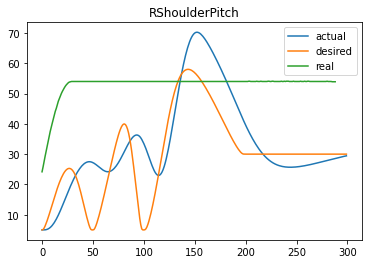

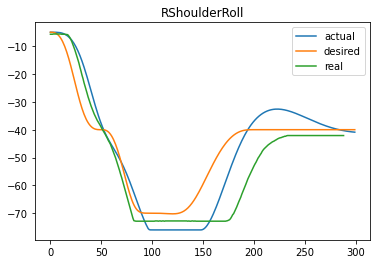

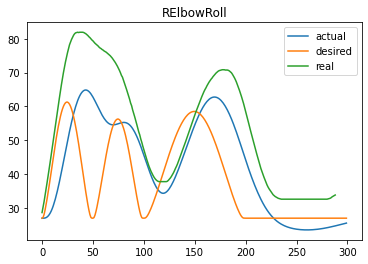

In [19]:
import numpy as np  
import matplotlib.pyplot as plt
actual_angles_deg = np.loadtxt('actual_angles_deg.csv', delimiter=',')
desired_angles_deg = np.loadtxt('desired_angles_deg.csv', delimiter=',')
actual_angles_real = np.loadtxt('actual_angles_real.csv', delimiter=',')
NAMES = ['RShoulderPitch', 'RShoulderRoll', 'RElbowRoll']
for i, name in enumerate(NAMES):
    plt.plot(actual_angles_deg[:,i], label='actual')
    plt.plot(desired_angles_deg[:, i], label='desired')
    plt.plot(actual_angles_real[:, i], label='real')
    plt.legend()
    plt.title(name)
    plt.show()

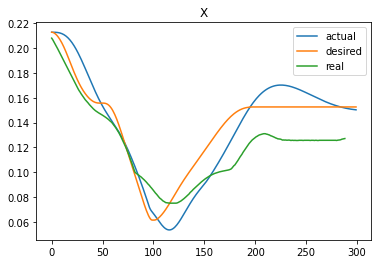

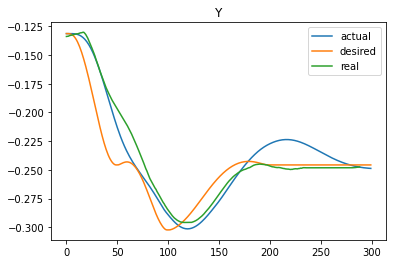

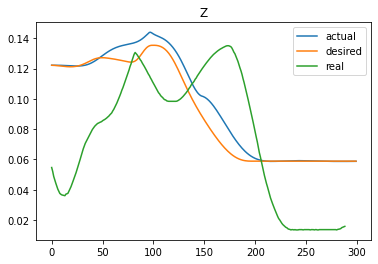

In [26]:
import numpy as np  
import matplotlib.pyplot as plt
NAMES = ['X', 'Y', 'Z']
actual_coord_sim = np.array([PoE_3D(t1, t2, t3) for t1, t2, t3 in np.deg2rad(actual_angles_deg)])
desired_coord = np.array([PoE_3D(t1, t2, t3) for t1, t2, t3 in np.deg2rad(desired_angles_deg)])
actual_coord_real = np.array([PoE_3D(t1, t2, t3) for t1, t2, t3 in np.deg2rad(actual_angles_real)])
for i, name in enumerate(NAMES):
    plt.plot(actual_coord_sim[:,i], label='actual')
    plt.plot(desired_coord[:, i], label='desired')
    plt.plot(actual_coord_real[:, i], label='real')
    plt.legend()
    plt.title(name)
    plt.show()
    

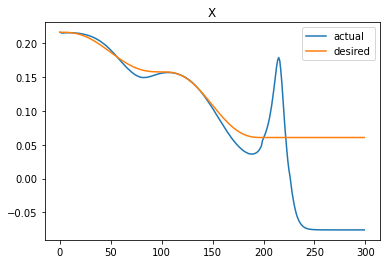

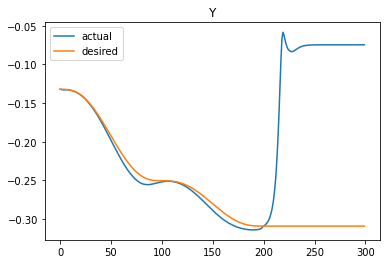

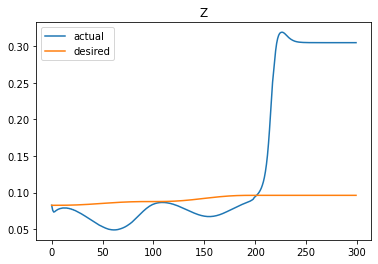

In [11]:
NAMES = ['X', 'Y', 'Z']
actual_coors = np.loadtxt('traj_act_coor.csv', delimiter=',')
desired_coors = np.loadtxt('traj_des_coor.csv', delimiter=',')
for i, name in enumerate(NAMES):
    plt.plot(actual_coors[:,i], label='actual')
    plt.plot(desired_coors[:,i], label='desired')
    plt.legend()
    plt.title(name)
    plt.show()

In [ ]:
xyz = [[0.2165269048192407, 0.21652207556751119, 0.21648946064209207, 0.21640447921183573, 0.21624591086301734, 0.21599574624744927, 0.2156390377305957, 0.21516375003968707, 0.2145606109118349, 0.213822961742146, 0.21294660823183725, 0.21192967103634996, 0.21077243641346466, 0.20947720687141538, 0.20804815181700434, 0.20649115820371658, 0.20481368117983428, 0.20302459473655152, 0.20113404235608862, 0.19915328765980694, 0.19709456505632325, 0.1949709303896242, 0.19279611158718118, 0.1905843593080645, 0.18835029759105815, 0.18610877450277435, 0.18387471278576803, 0.18166296050665132, 0.1794881417042083, 0.17736450703750928, 0.17530578443402553, 0.17332502973774386, 0.17143447735728098, 0.1696453909139982, 0.16796791389011592, 0.16641092027682813, 0.16498186522241717, 0.16368663568036781, 0.16252940105748248, 0.1615124638619952, 0.16063611035168643, 0.15989846118199755, 0.15929532205414537, 0.15882003436323686, 0.15846332584638326, 0.15821316123081514, 0.1580545928819967, 0.15796961145174043, 0.1579369965263214, 0.1579321672745918, 0.1579321672745918, 0.1579241650320374, 0.15787012093603328, 0.15772930367165752, 0.15746655025564846, 0.1570520185549974, 0.1564609398055418, 0.15567337113055774, 0.15467394805935325, 0.15345163704586084, 0.1519994879872306, 0.1503143867424228, 0.1483968076508012, 0.14625056605072556, 0.1438825707981446, 0.14130257678518907, 0.13852293745876434, 0.13555835733914354, 0.1324256445385602, 0.12914346327980136, 0.12573208641480035, 0.12221314794322957, 0.11860939553109352, 0.11494444302932164, 0.11124252299236116, 0.1075282391967699, 0.10382631915980942, 0.10016136665803749, 0.09655761424590147, 0.0930386757743307, 0.08962729890932966, 0.08634511765057082, 0.08321240484998751, 0.08024782473036668, 0.07746818540394199, 0.0748881913909864, 0.07252019613840556, 0.0703739545383298, 0.06845637544670817, 0.06677127420190035, 0.06531912514327014, 0.06409681412977775, 0.06309739105857322, 0.06230982238358931, 0.061718743634133655, 0.06130421193348262, 0.06104145851747341, 0.06090064125309775, 0.0608465971570938, 0.06083859491453924, 0.06083859491453924, 0.06083937805352699, 0.0608447648143419, 0.06085909961409288, 0.06088644941131717, 0.060930609547213424, 0.06099510958687485, 0.061083219160522215, 0.061197953804736985, 0.061342080803694424, 0.06151812503039665, 0.061728374787905715, 0.06197488765057673, 0.06225949630529094, 0.06258381439268879, 0.06294924234840302, 0.06335697324429179, 0.06380799862967171, 0.06430311437255096, 0.06484292650086239, 0.06542785704369657, 0.06605814987253492, 0.06673387654248275, 0.0674549421335024, 0.06822109109164627, 0.06903191307028995, 0.06988684877136535, 0.07078519578659362, 0.07172611443871847, 0.07270863362273908, 0.07373165664714322, 0.07479396707514041, 0.07589423456589499, 0.07703102071575908, 0.07820278489950586, 0.07940789011156252, 0.08064460880724342, 0.0819111287439831, 0.08320555882256947, 0.08452593492837682, 0.08587022577259895, 0.08723633873348219, 0.08862212569755862, 0.090025388900879, 0.09144388677024598, 0.09287533976444712, 0.09431743621548799, 0.09576783816982531, 0.09722418722959997, 0.09868411039387007, 0.10014522589984416, 0.10160514906411425, 0.10306149812388889, 0.10451190007822621, 0.10595399652926706, 0.10738544952346825, 0.10880394739283522, 0.11020721059615561, 0.111592997560232, 0.11295911052111528, 0.1143034013653374, 0.11562377747114475, 0.11691820754973109, 0.11818472748647077, 0.1194214461821517, 0.12062655139420833, 0.12179831557795508, 0.12293510172781924, 0.12403536921857379, 0.125097679646571, 0.12612070267097514, 0.12710322185499565, 0.12804414050712062, 0.12894248752234885, 0.12979742322342425, 0.13060824520206799, 0.13137439416021182, 0.13209545975123146, 0.1327711864211793, 0.13340147925001763, 0.13398640979285184, 0.1345262219211632, 0.13502133766404253, 0.13547236304942242, 0.13588009394531125, 0.13624552190102537, 0.13656983998842329, 0.1368544486431375, 0.1371009615058085, 0.1373112112633175, 0.1374872554900198, 0.13763138248897724, 0.13774611713319193, 0.13783422670683937, 0.13789872674650072, 0.13794288688239711, 0.13797023667962147, 0.13798457147937226, 0.13798995824018737, 0.13799074137917497], [-0.13206076875311867, -0.1320705292590678, -0.13213644799584395, -0.13230820581714636, -0.13262869176376343, -0.13313430492192432, -0.13385525628165074, -0.13481587059510827, -0.13603488823495816, -0.13752576705270872, -0.13929698423706716, -0.14135233817229098, -0.14369125029653965, -0.14630906696022614, -0.14919736128436853, -0.15234423501894168, -0.15573462040122876, -0.15935058201417274, -0.16317161864472815, -0.1671749651422126, -0.17133589427665835, -0.17562801859716387, -0.18002359229024553, -0.18449381303818913, -0.18900912387740146, -0.19353951505676203, -0.19805482589597434, -0.20252504664391796, -0.20692062033699962, -0.2112127446575051, -0.21537367379195088, -0.21937702028943534, -0.22319805691999073, -0.2268140185329347, -0.23020440391522176, -0.23335127764979496, -0.23623957197393725, -0.23885738863762385, -0.24119630076187254, -0.24325165469709645, -0.24502287188145483, -0.2465137506992054, -0.2477327683390553, -0.24869338265251267, -0.24941433401223911, -0.24991994717040003, -0.2502404331170172, -0.2504121909383195, -0.2504781096750955, -0.2504878701810448, -0.2504878701810448, -0.2504927135935172, -0.25052542415519646, -0.2506106547752351, -0.2507696880916612, -0.25102058626120594, -0.2513783407491312, -0.2518550221190575, -0.252459929822792, -0.25319974199015555, -0.2540786652188114, -0.2550985843640921, -0.2562592123288278, -0.2575582398531739, -0.2589914853044385, -0.26055304446691074, -0.2622354403316881, -0.2640297728865043, -0.2659258689055571, -0.267912431739336, -0.26997719110445006, -0.2721070528734557, -0.2742882488646844, -0.2765064866320702, -0.2787470992549783, -0.28099519512803167, -0.28323580775093965, -0.2854540455183256, -0.2876352415095542, -0.28976510327855987, -0.29182986264367394, -0.29381642547745285, -0.2957125214965056, -0.2975068540513218, -0.29918924991609913, -0.30075080907857143, -0.30218405452983604, -0.3034830820541821, -0.3046437100189179, -0.30566362916419865, -0.3065425523928544, -0.307282364560218, -0.3078872722639525, -0.30836395363387875, -0.308721708121804, -0.3089726062913487, -0.3091316396077749, -0.3092168702278135, -0.3092495807894926, -0.30925442420196514, -0.30925442420196514, -0.30925382768739307, -0.3092497246081538, -0.3092388058350211, -0.30921797357811465, -0.3091843369376498, -0.30913520745468914, -0.30906809466189233, -0.3089807016342672, -0.30887092053992027, -0.30873682819080706, -0.3085766815934833, -0.3083889134998548, -0.3081721279579289, -0.3079250958625644, -0.30764675050622253, -0.30733618312971767, -0.3069926384729674, -0.30661551032574397, -0.3062043370784241, -0.30575879727274013, -0.3052787051525306, -0.30476400621449046, -0.30421477275892217, -0.3036311994404861, -0.3030135988189511, -0.30236239690994543, -0.30167812873570676, -0.30096143387583363, -0.3002130520180353, -0.2994338185088827, -0.2986246599045592, -0.2977865895216111, -0.2969207029876979, -0.29602817379234364, -0.29511024883768694, -0.2941682439892317, -0.29320353962659806, -0.2922175761942726, -0.29121184975235914, -0.2901879075273296, -0.28914734346277404, -0.2880917937701519, -0.28702293247954225, -0.28594246699039444, -0.2848521336222789, -0.2837536931656376, -0.2826489264325347, -0.2815396298074072, -0.28042761079781553, -0.27931468358519435, -0.2782026645756027, -0.27709336795047523, -0.27598860121737234, -0.27489016076073103, -0.2737998273926155, -0.2727193619034677, -0.271650500612858, -0.2705949509202359, -0.26955438685568034, -0.26853044463065073, -0.26752471818873735, -0.26653875475641187, -0.26557405039377824, -0.264632045545323, -0.2637141205906663, -0.262821591395312, -0.26195570486139885, -0.2611176344784507, -0.2603084758741272, -0.25952924236497465, -0.25878086050717636, -0.2580641656473031, -0.2573798974730645, -0.2567286955640588, -0.2561110949425238, -0.25552752162408776, -0.2549782881685195, -0.2544635892304793, -0.25398349711026974, -0.25353795730458584, -0.25312678405726596, -0.25274965591004245, -0.25240611125329226, -0.2520955438767873, -0.2518171985204456, -0.251570166425081, -0.2513533808831551, -0.25116561278952665, -0.2510054661922029, -0.2508713738430896, -0.25076159274874266, -0.25067419972111765, -0.2506070869283208, -0.2505579574453602, -0.2505243208048953, -0.2505034885479887, -0.2504925697748562, -0.2504884666956167, -0.2504878701810448], [0.08270090974292187, 0.08270133224770151, 0.08270418568393743, 0.08271162059569508, 0.08272549352861071, 0.08274738009648824, 0.08277858804789606, 0.08282017033276398, 0.08287293816897998, 0.08293747410898705, 0.08301414510638022, 0.08310311558250319, 0.08320436049304537, 0.08331767839463855, 0.08344270451145394, 0.08357892380179888, 0.08372568402471378, 0.08388220880656896, 0.0840476107076614, 0.08422090428881178, 0.08440101917796118, 0.084586813136768, 0.08477708512720479, 0.08497058837815513, 0.08516604345201045, 0.0853621513112669, 0.0855576063851222, 0.08575110963607255, 0.08594138162650933, 0.08612717558531616, 0.08630729047446556, 0.08648058405561594, 0.08664598595670839, 0.08680251073856354, 0.08694927096147846, 0.08708549025182341, 0.08721051636863879, 0.08732383427023198, 0.08742507918077413, 0.08751404965689713, 0.08759072065429029, 0.08765525659429738, 0.08770802443051334, 0.08774960671538128, 0.08778081466678911, 0.08780270123466663, 0.08781657416758228, 0.0878240090793399, 0.08782686251557582, 0.08782728502035547, 0.08782728502035547, 0.08782798512586176, 0.08783271337159265, 0.08784503328585425, 0.08786802123105776, 0.08790428805553684, 0.08795600074536529, 0.08802490407617453, 0.08811234226497118, 0.08821928062195465, 0.08834632720233464, 0.08849375445814875, 0.08866152089007998, 0.08884929269927433, 0.08905646543915836, 0.08928218566725672, 0.08952537259700973, 0.08978473974959089, 0.09005881660572446, 0.09034597025750311, 0.09064442706020531, 0.090952294284113, 0.0912675817663291, 0.09158822356259512, 0.09191209959910862, 0.0922370573243409, 0.09256093336085441, 0.09288157515712042, 0.09319686263933655, 0.09350472986324422, 0.09380318666594642, 0.09409034031772506, 0.09436441717385866, 0.09462378432643981, 0.0948669712561928, 0.09509269148429116, 0.09529986422417519, 0.09548763603336956, 0.09565540246530081, 0.0958028297211149, 0.0959298763014949, 0.09603681465847837, 0.09612425284727502, 0.09619315617808424, 0.0962448688679127, 0.09628113569239179, 0.09630412363759529, 0.09631644355185691, 0.09632117179758774, 0.09632187190309406, 0.09632187190309406, 0.09632111975413152, 0.09631594615580259, 0.09630217860632607, 0.0962759110830262, 0.09623349843224609, 0.09617155075926134, 0.09608692781819367, 0.09597673340192435, 0.09583830973200794, 0.09566923184858575, 0.09546730200029942, 0.09523054403420453, 0.0949571977856842, 0.09464571346836252, 0.09429474606401829, 0.09390314971249854, 0.09346997210163197, 0.09299444885714275, 0.09247599793256395, 0.09191421399915106, 0.09130886283579574, 0.09065987571893923, 0.08996734381248597, 0.08923151255771723, 0.08845277606320459, 0.08763167149472359, 0.08676887346516723, 0.0858651884244596, 0.08492154904946947, 0.08393900863392373, 0.08291873547832111, 0.08186200727984569, 0.08077020552228048, 0.07964480986592098, 0.07848739253748878, 0.07729961272004506, 0.07608321094290423, 0.07484000347154754, 0.07357187669753651, 0.07228078152842665, 0.07096872777768097, 0.0696377785545835, 0.06829004465415293, 0.0669276789470562, 0.06555287076952201, 0.06416784031325438, 0.06277483301534634, 0.06137611394819331, 0.0599739622094069, 0.05857066531172829, 0.05716851357294189, 0.055769794505788894, 0.05437678720788082, 0.052991756751613245, 0.05161694857407899, 0.050254582866982256, 0.04890684896655171, 0.04757589974345426, 0.04626384599270855, 0.0449727508235987, 0.04370462404958769, 0.04246141657823102, 0.0412450148010902, 0.04005723498364643, 0.03889981765521425, 0.037774421998854765, 0.0366826202412895, 0.035625892042814106, 0.03460561888721149, 0.03362307847166576, 0.032679439096675686, 0.03177575405596794, 0.030912956026411635, 0.030091851457930623, 0.029313114963417965, 0.028577283708649252, 0.02788475180219599, 0.027235764685339458, 0.02663041352198415, 0.026068629588571254, 0.0255501786639925, 0.025074655419503204, 0.02464147780863668, 0.02424988145711685, 0.02389891405277274, 0.023587429735450992, 0.023314083486930634, 0.023077325520835797, 0.022875395672549547, 0.022706317789127253, 0.022567894119210855, 0.022457699702941616, 0.022373076761873865, 0.02231112908888919, 0.02226871643810896, 0.022242448914809015, 0.02222868136533268, 0.02222350776700357, 0.022222755618041157]]

for x, y, z in zip(xyz[0], xyz[1], xyz[2]):
    angles = ik